# What does this Notebook do?

ARIMA documentation:
<br>https://medium.com/@stallonejacob/time-series-forecast-a-basic-introduction-using-python-414fcb963000
<br>https://towardsdatascience.com/an-end-to-end-project-on-time-series-analysis-and-forecasting-with-python-4835e6bf050b
<br>https://www.statsmodels.org/devel/generated/statsmodels.tsa.arima_model.ARIMA.html
<br>https://machinelearningmastery.com/make-sample-forecasts-arima-python/
<br>https://towardsdatascience.com/the-complete-guide-to-time-series-analysis-and-forecasting-70d476bfe775
<br>https://otexts.com/fpp2/stationarity.html

Hydroeval documentation: https://thibhlln.github.io/hydroeval/tutorial.html

This workflow needs tweaking for real-time forecasting - e.g. we won't have all SWE data available by the forecast start date so need to replace a few months with with climatological SWE data (e.g. median, max or min - could be useful to make decisions)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import itertools
import warnings
from scipy import stats
import hydroeval
from hydroeval import evaluator, kge, kgeprime
import statsmodels.formula.api as smf
import operator
from statsmodels.tsa.arima_model import ARIMAResults

### Read SWE & Q data

In [57]:
# Reading basins' station ids
%store -r basinno

# Reading SWE
%store -r SWE_normmonthlybasinmeans_ds
display(SWE_normmonthlybasinmeans_ds)

# Reading Q
%store -r stationsq_fcaggreg_da
display(stationsq_fcaggreg_da)

<xarray.DataArray 'SWE' (basin_id: 1, time: 1001)>
array([[-0.65136013, -1.48851374, -1.48851374, ...,  1.0725916 ,
        -0.71222019, -1.46164527]])
Coordinates:
  * time      (time) datetime64[ns] 1937-03-01 1937-04-01 ... 2020-07-01
  * basin_id  (basin_id) <U7 '05BB001'
Attributes:
    info:     Normalized basin monthly SWE (snow water equivalent) averages. ...
    units:    kg m-2 or mm

<xarray.DataArray 'Qmean' (Station_ID: 9, time: 2041)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * time          (time) datetime64[ns] 1850-01-01 1850-02-01 ... 2020-01-01
    lat           (Station_ID) float64 51.17 49.61 54.0 ... 45.4 47.36 47.08
    lon           (Station_ID) float64 -115.6 -115.6 -122.6 ... -68.32 -75.75
  * Station_ID    (Station_ID) object '05BB001' '08NG065' ... '02LG005'
    Station_Name  (Station_ID) object 'BOW RIVER AT BANFF' ... 'GATINEAU (RIVIERE) AUX RAPIDES CEIZUR'
Attributes:
    long_name:  Monthly flow averages
    info:       Calculated for months without missing data
    units:      m**3 s**-1

# ARIMA forecasting tests

## Some preliminary timeseries checks for stationarity and seasonality

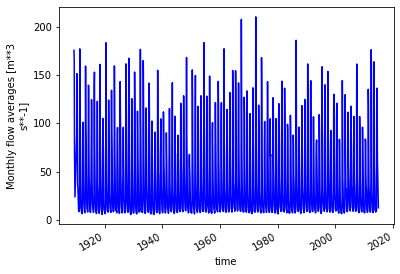

In [7]:
# Plotting raw Q timeseries for a given basin

basin_of_interest = '05BB001'
timeseries = stationsq_fcaggreg_da[stationsq_fcaggreg_da['Station_ID']=='05BB001'].dropna(dim='time',how='all')
timeseries.plot(color='b')
plt.title('');

### Checking stationarity

<xarray.DataArray (Station_ID: 1, time: 1259)>
array([[nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * time          (time) datetime64[ns] 1909-06-01 1909-07-01 ... 2014-12-01
    lat           (Station_ID) float64 51.17
    lon           (Station_ID) float64 -115.6
  * Station_ID    (Station_ID) object '05BB001'
    Station_Name  (Station_ID) object 'BOW RIVER AT BANFF'

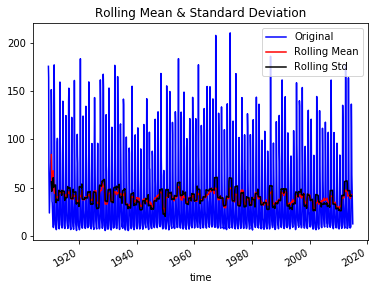

Results of Dickey-Fuller Test:
Test Statistic                -6.484751e+00
p-value                        1.269059e-08
#Lags Used                     2.300000e+01
Number of Observations Used    1.235000e+03
Critical Value (1%)           -3.435656e+00
Critical Value (5%)           -2.863883e+00
Critical Value (10%)          -2.568018e+00
dtype: float64


In [8]:
# In order to apply a time series model, it is important for the time series to be stationary
# In other words, the trend is the same over time and the timeseries statistical properties (mean, variance) 
# remain constant over time
# It's important that the "behavior" of the timeseries is the same over time in order to be able to forecast it

def test_stationarity(timeseries, var):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(time=12, center=True).mean()
    rolstd = timeseries.rolling(time=12, center=True).std()
    
    display(rolmean)
    
    #Plot rolling statistics:
    timeseries.plot(color='blue',label='Original')
    rolmean.plot(color='red', label='Rolling Mean')
    rolstd.plot(color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test
    print('Results of Dickey-Fuller Test:')
    if var == 'q':
        dftest = adfuller(timeseries.data[0], autolag='AIC')
    elif var == 'swe':
        dftest = adfuller(timeseries.data, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
test_stationarity(timeseries, var='q')

This timeseries is stationary because its statistical properties do not change over time. In other words, it has constant mean and variance. The Dickey-Fuller test is a statistical test that we run to determine if a time series is stationary or not. It tests the null hypothesis that the timeseries is non-stationary. If p>0, the process is not stationary. Otherwise, p=0, the null hypothesis is rejected, and the process is considered to be stationary. Here, the test statistic is smaller than the 1% critical values. That tells us that we are 99% confident that this series is indeed stationary.

So we don't need to make it stationary and can jump to the next step!

### Checking seasonality

In [11]:
# Saving Qobs to pandas dataframe

timeseries_df = timeseries.to_dataframe()
q_df = timeseries_df.reset_index()
q_df = q_df.drop(columns=['lat', 'lon', 'Station_Name', 'Station_ID'])
q_df = q_df.set_index('time')
q_df.index = pd.DatetimeIndex(q_df.index)
q_df = q_df.rename(columns={"Qmean": 'Qobs'})
q_df = q_df['1911-01-01':]
display(q_df)

,Qobs
time,
1911-01-01,9.822258
1911-02-01,9.253929
1911-03-01,8.558710
1911-04-01,10.384333
1911-05-01,35.093548
...,...
2014-08-01,63.532258
2014-09-01,49.040000
2014-10-01,32.967742


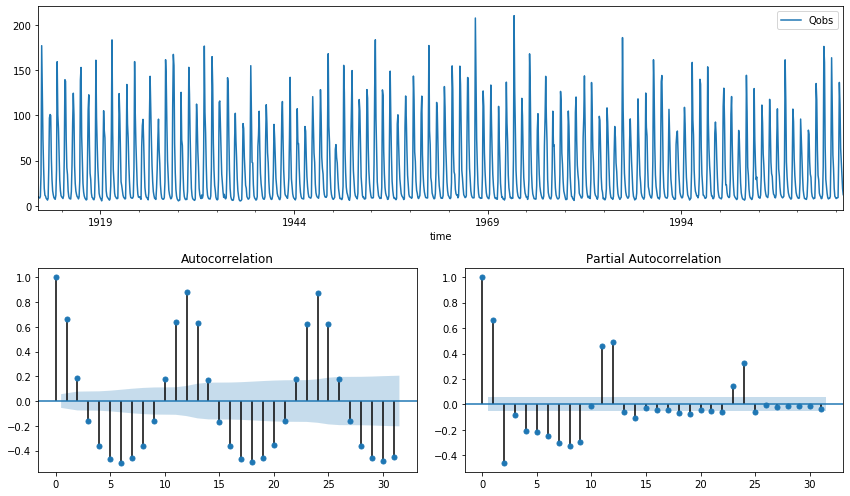

In [12]:
# Plotting Qobs timeseries and (partial) autocorrelation

fig = plt.figure(figsize=(12, 7))
layout = (2,2)
ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
acf_ax = plt.subplot2grid(layout, (1,0))
pacf_ax = plt.subplot2grid(layout, (1,1))

q_df.plot(ax=ts_ax)
sm.graphics.tsa.plot_acf(q_df.values, ax=acf_ax)
sm.graphics.tsa.plot_pacf(q_df.values, ax=pacf_ax)

plt.tight_layout();

Above is an example of an autocorrelation plot for Qobs. Looking closely, you realize that the first value and the 6th value have a high autocorrelation. Similarly, the 6th and 12th observations are highly correlated. This means that we will find a very similar value at every 6 unit of time. Notice how the plot looks like sinusoidal function. This is a hint for seasonality, and you can find its value by finding the period in the plot above, which would give 6 months.

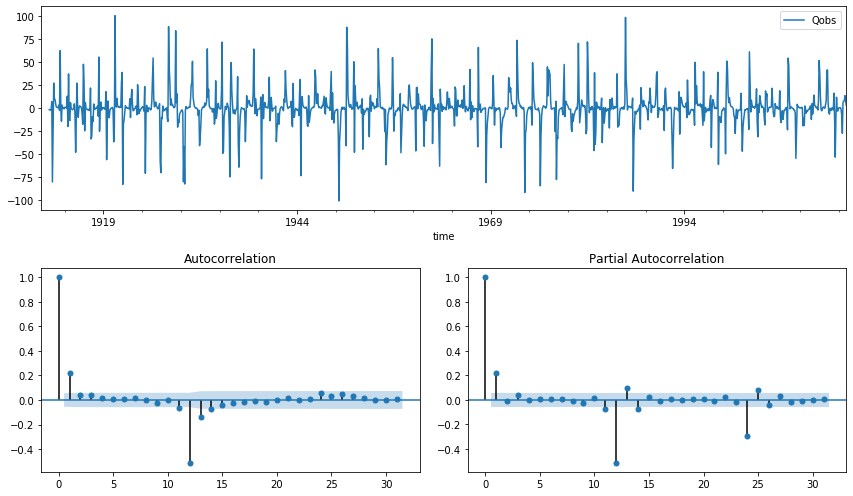

In [13]:
# To get rid of the high autocorrelation and hence seasonality, let’s take the first difference
# We simply subtract the time series from itself with a lag of X time steps (defined by the shift parameter)
# Note: this means that we won't have any data anymore for the first X time steps

shift = 12

q_df_diff = q_df - q_df.shift(shift)

fig = plt.figure(figsize=(12, 7))
layout = (2,2)
ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
acf_ax = plt.subplot2grid(layout, (1,0))
pacf_ax = plt.subplot2grid(layout, (1,1))

q_df_diff.plot(ax=ts_ax)
sm.graphics.tsa.plot_acf(q_df_diff[shift:].values, ax=acf_ax)
sm.graphics.tsa.plot_pacf(q_df_diff[shift:].values, ax=pacf_ax)

plt.tight_layout();

# Future: If this doesn't work 100%, we could do this a second time with a different time step

This more or less worked... Might need a second shift?

In [69]:
# # Second shift

# second_shift = 1

# q_df_diff_diff = q_df_diff -  (q_df.shift(second_shift) - q_df_diff.shift(second_shift))
# display(q_df_diff_diff)

# fig = plt.figure(figsize=(12, 7))
# layout = (2,2)
# ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
# acf_ax = plt.subplot2grid(layout, (1,0))
# pacf_ax = plt.subplot2grid(layout, (1,1))

# q_df_diff_diff.plot(ax=ts_ax)
# sm.graphics.tsa.plot_acf(q_df_diff_diff[shift+second_shift:].values, ax=acf_ax)
# sm.graphics.tsa.plot_pacf(q_df_diff_diff[shift+second_shift:].values, ax=pacf_ax)

# plt.tight_layout();

## Forecasting

### ARIMA forecasting
ARIMA, short for 'Auto Regressive Integrated Moving Average' is actually a class of models that 'explains' a given time series based on its own past values, that is, its own lags and the lagged forecast errors, so that equation can be used to forecast future values

In [14]:
# Splitting the dataset into a training and validation timeseries for forecasting

# Removing NA values before splitting dataset
q_df_diff = q_df_diff.dropna()

# Here we split the timeseries in half
# split_point = int(len(q_df.index)/2)
# split_point = int(len(res_df.index)/2)
split_point = int(len(q_df_diff.index)/2)
# dataset, validation = q_df[0:split_point], q_df[split_point:]
# dataset, validation = res_df[0:split_point], res_df[split_point:]
training_qdiff, validation_qdiff = q_df_diff[0:split_point], q_df_diff[split_point:]
display(training_qdiff, validation_qdiff)

,Qobs
time,
1912-01-01,-1.592581
1912-02-01,-1.707032
1912-03-01,-2.218710
1912-04-01,-2.041667
1912-05-01,6.945161
...,...
1963-02-01,0.727500
1963-03-01,0.230968
1963-04-01,-1.946667


,Qobs
time,
1963-07-01,5.816129
1963-08-01,-0.883871
1963-09-01,10.456667
1963-10-01,3.777419
1963-11-01,0.273333
...,...
2014-08-01,7.416129
2014-09-01,7.936667
2014-10-01,13.529032


In [15]:
# Setting the ARIMA parameters ranges
# ARIMA models are denoted with the notation ARIMA(p, d, q)
# SARIMAX is a seasonal version of the model, with an additional s parameter
# p represents the max. lag. The lag after which most lags are not significant in the PAC plot
# d represents the number of differences required to make the series stationary
# q represents the biggest lag after which other lags are not significant on the AC plot
# s represents a season’s length

p = range(1, 5)
d = range(1, 2)
q = range(1, 5)
pdq = list(itertools.product(p, d, q))
s = 12
seasonal_pdq = [(x[0], x[1], x[2], s) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (1, 1, 2) x (1, 1, 2, 12)
SARIMAX: (1, 1, 2) x (1, 1, 3, 12)
SARIMAX: (1, 1, 3) x (1, 1, 4, 12)
SARIMAX: (1, 1, 3) x (2, 1, 1, 12)


In [104]:
# Looking for optimal set of SARIMAX parameters
# We loop through the SARIMAX parameters values combinations to find the optimal set of parameters 
# i.e. the set that yields the best model performance in terms of AIC (Akaike info. criterion; the lower the better)

warnings.filterwarnings("ignore")

it = 0 

print('running...')

for param in pdq:
    print(param)
    for param_seasonal in seasonal_pdq:
        print(param_seasonal)
        try:
            it += 1
            model = sm.tsa.statespace.SARIMAX(training_qdiff, order=param, seasonal_order=param_seasonal, enforce_stationarity=False, enforce_invertibility=False)
            model_fit = model.fit()
            if it == 1:
                AIC_best_score = model_fit.aic
                param_best_score = param
                param_seas_best_score = param_seasonal
            elif it > 1:
                if model_fit.aic < AIC_best_score:
                    AIC_best_score = model_fit.aic
                    param_best_score = param
                    param_seas_best_score = param_seasonal
        except:
            continue
            
print('The best parameters are: ','SARIMAX{}'.format(param_best_score),' x {}'.format(param_seas_best_score),'- AIC:{}'.format(AIC_best_score))

print('finished running.')

running...
(1, 1, 1)
(1, 1, 1, 12)
(1, 1, 2, 12)
(1, 1, 3, 12)
(1, 1, 4, 12)
(2, 1, 1, 12)
(2, 1, 2, 12)
(2, 1, 3, 12)
(2, 1, 4, 12)
(3, 1, 1, 12)
(3, 1, 2, 12)
(3, 1, 3, 12)
(3, 1, 4, 12)
(4, 1, 1, 12)
(4, 1, 2, 12)
(4, 1, 3, 12)
(4, 1, 4, 12)
(1, 1, 2)
(1, 1, 1, 12)
(1, 1, 2, 12)
(1, 1, 3, 12)
(1, 1, 4, 12)
(2, 1, 1, 12)
(2, 1, 2, 12)
(2, 1, 3, 12)
(2, 1, 4, 12)
(3, 1, 1, 12)
(3, 1, 2, 12)
(3, 1, 3, 12)
(3, 1, 4, 12)
(4, 1, 1, 12)
(4, 1, 2, 12)
(4, 1, 3, 12)
(4, 1, 4, 12)
(1, 1, 3)
(1, 1, 1, 12)
(1, 1, 2, 12)
(1, 1, 3, 12)
(1, 1, 4, 12)
(2, 1, 1, 12)
(2, 1, 2, 12)
(2, 1, 3, 12)
(2, 1, 4, 12)
(3, 1, 1, 12)
(3, 1, 2, 12)
(3, 1, 3, 12)
(3, 1, 4, 12)
(4, 1, 1, 12)
(4, 1, 2, 12)
(4, 1, 3, 12)
(4, 1, 4, 12)
(1, 1, 4)
(1, 1, 1, 12)
(1, 1, 2, 12)
(1, 1, 3, 12)
(1, 1, 4, 12)
(2, 1, 1, 12)
(2, 1, 2, 12)
(2, 1, 3, 12)
(2, 1, 4, 12)
(3, 1, 1, 12)
(3, 1, 2, 12)
(3, 1, 3, 12)
(3, 1, 4, 12)
(4, 1, 1, 12)
(4, 1, 2, 12)
(4, 1, 3, 12)
(4, 1, 4, 12)
(2, 1, 1)
(1, 1, 1, 12)
(1, 1, 2, 12)
(1, 1, 3, 12)
(

In [15]:
# Fitting the model using the optimal parameter set

warnings.filterwarnings("ignore")

# model = sm.tsa.statespace.SARIMAX(training_qdiff, order=param_best_score, seasonal_order=param_seas_best_score, enforce_stationarity=False, enforce_invertibility=False)
# To bypass re-running the cell above
model = sm.tsa.statespace.SARIMAX(training_qdiff, order=(1, 0, 2), seasonal_order=(2, 1, 4, 12), enforce_stationarity=False, enforce_invertibility=False)
model_fit = model.fit()

# We print a summary of the model
print(model_fit.summary()) 

                                           SARIMAX Results                                           
Dep. Variable:                                          Qobs   No. Observations:                  618
Model:             SARIMAX(1, 0, 2)x(2, 1, [1, 2, 3, 4], 12)   Log Likelihood               -2300.359
Date:                                       Tue, 09 Mar 2021   AIC                           4620.717
Time:                                               14:40:46   BIC                           4663.907
Sample:                                           01-01-1912   HQIC                          4637.588
                                                - 06-01-1963                                         
Covariance Type:                                         opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2677     

In [16]:
# Saving model

model_fit.save('arima_model.pkl', remove_data=False)

# To load model back do: loaded = ARIMAResults.load('arima_model.pkl')

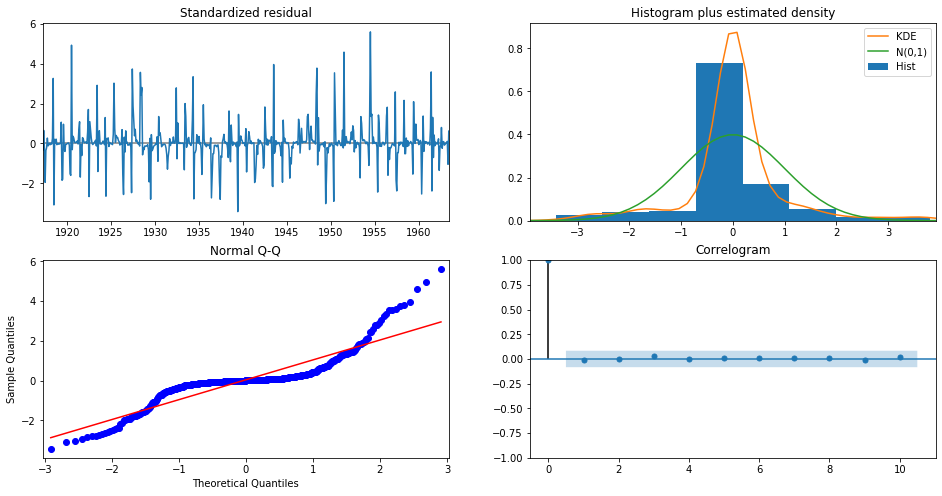

In [17]:
# Plotting some model diagnostics

model_fit.plot_diagnostics(figsize=(16, 8))
plt.show()

Our model diagnostics suggest that the model residuals are near normally distributed, which we want

In [61]:
# Out of sample forecasting

# We now generate forecasts for the time series we left out for the validation
start_index = split_point
end_index = split_point + len(validation_qdiff)
fcst = model_fit.get_forecast(steps = end_index - start_index)
print(fcst.summary_frame(alpha=0.5))

Qobs            mean    mean_se  mean_ci_lower  mean_ci_upper
1963-07-01  0.505075  14.437319      -9.232748      10.242899
1963-08-01 -9.952340  14.833026     -19.957064       0.052384
1963-09-01 -0.745665  14.833974     -10.751029       9.259698
1963-10-01  0.143081  14.834042      -9.862328      10.148490
1963-11-01 -1.787475  14.834047     -11.792887       8.217937
...              ...        ...            ...            ...
2014-08-01 -0.368952  20.656800     -14.301752      13.563848
2014-09-01 -0.186160  20.656800     -14.118960      13.746640
2014-10-01 -0.076109  20.656800     -14.008909      13.856691
2014-11-01  0.001353  20.656800     -13.931447      13.934153
2014-12-01  0.017582  20.656800     -13.915218      13.950382

[618 rows x 4 columns]


In [19]:
# Writing forecast to new DataFrame

# We save the forecast mean & confidence intervals to a new DataFrame
forecast_df = pd.DataFrame(fcst.predicted_mean.values, index=validation_qdiff.index, columns=["Qfc"])
forecast_df['lower_conf_int'] = fcst.conf_int(alpha=0.05)['lower Qobs'].values
forecast_df['upper_conf_int'] = fcst.conf_int(alpha=0.05)['upper Qobs'].values

# We need to transform the forecast values back (remember the data differencing step?)
shifted_q_df = q_df.shift(shift)
shifted_q_df = shifted_q_df.loc[forecast_df.index]
forecast_df = forecast_df.add(shifted_q_df.values, axis=0)

# We set all negative forecast values to 0, just in case
forecast_df[forecast_df < 0] = 0
display(forecast_df)

,Qfc,lower_conf_int,upper_conf_int
time,,,
1963-07-01,104.021204,75.724579,132.317829
1963-08-01,58.450886,29.378690,87.523082
1963-09-01,34.734335,5.660280,63.808389
1963-10-01,22.359210,0.000000,51.433398
1963-11-01,14.392525,0.000000,43.466722
...,...,...,...
2014-08-01,55.747177,15.260593,96.233762
2014-09-01,40.917174,0.430589,81.403758
2014-10-01,19.362601,0.000000,59.849185


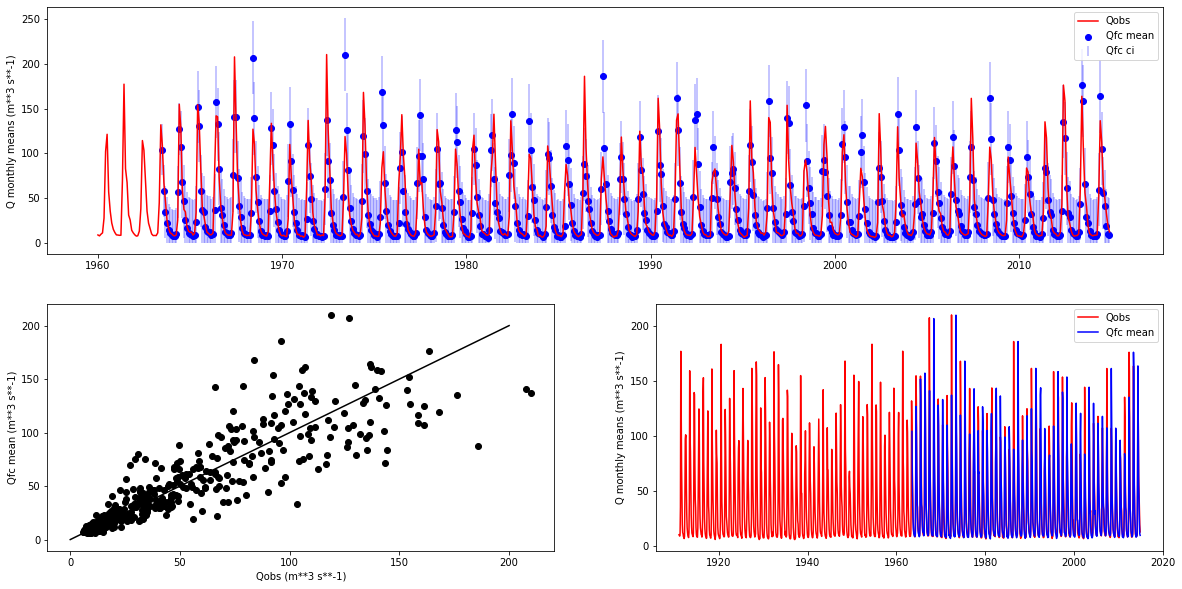

In [20]:
# Forecast plots

# Setting up figure
fig = plt.figure(figsize=(20, 10))
layout = (2,2)
ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
scatter_ax = plt.subplot2grid(layout, (1,0))
tsmean_ax = plt.subplot2grid(layout, (1,1))

# Calculating error bars for timeseries plot
errors = np.zeros((2,len(forecast_df.index)))
errors[0,:] = forecast_df['Qfc'].values - forecast_df['lower_conf_int'].values
errors[1,:] = forecast_df['upper_conf_int'].values - forecast_df['Qfc'].values

# Timeseries plot
ts_ax.plot(q_df['1960':].index, q_df['1960':].values, color='red', label='Qobs')
ts_ax.scatter(forecast_df['Qfc'].index, forecast_df['Qfc'].values, color='blue', label='Qfc mean')
ts_ax.errorbar(forecast_df['Qfc'].index, forecast_df['Qfc'].values, yerr=errors, color='blue', alpha=.3, ls='none', label='Qfc ci')
ts_ax.set_ylabel('Q monthly means'+' ('+stationsq_fcaggreg_da.attrs['units']+')')
ts_ax.legend()

# Scatter plot forecast mean vs obs
scatter_ax.scatter(q_df.loc[validation_qdiff.index].values, forecast_df['Qfc'].values, color='k')
scatter_ax.plot([0,200], [0,200], color='k')
scatter_ax.set_xlabel('Qobs'+' ('+stationsq_fcaggreg_da.attrs['units']+')')
scatter_ax.set_ylabel('Qfc mean'+' ('+stationsq_fcaggreg_da.attrs['units']+')')

# # Forecast mean timeseries
tsmean_ax.plot(q_df.index, q_df.values, color='red', label='Qobs')
tsmean_ax.plot(forecast_df['Qfc'].index, forecast_df['Qfc'].values, color='blue', label='Qfc mean')
tsmean_ax.set_ylabel('Q monthly means'+' ('+stationsq_fcaggreg_da.attrs['units']+')')
tsmean_ax.legend();

Notice the 1 year "lag" between the observations and forecasts. This is the expected behavior as ARIMA only uses past information. Without additional information that can be used in forecasting we cannot do much better. Let's try and add some snow information below to improve the predictions.

In [21]:
# Calculating a few forecast verification metrics

print('SARIMAX forecast verification:')

# Correlation
r = stats.pearsonr(q_df.loc[forecast_df.index].values.flatten(), forecast_df['Qfc'].values)[0]
print('Correlation = ', round(r, 2))

# KGE
kge_prime_flow = kgeprime(q_df.loc[forecast_df.index].values.flatten(), forecast_df['Qfc'].values)[0][0]
kge_flow_inv = evaluator(kge, forecast_df['Qfc'].values, q_df.loc[forecast_df.index].values.flatten(), axis=1, transform='inv')[0][0]
print("KGE' = ", round(kge_prime_flow,2))
print('KGE (of inverse of flow) = ', round(kge_flow_inv,2))

SARIMAX forecast verification:
Correlation =  0.9
KGE' =  0.9
KGE (of inverse of flow) =  0.94


### Ordinary least squares (OLS) regression
To add some information about snow, we perform an OLS regression on SWE observations. OLS is a statistical method of analysis that estimates the relationship between one or more independent variables and a dependent variable; the method estimates the relationship by minimizing the sum of the squares in the difference between the observed and predicted values.

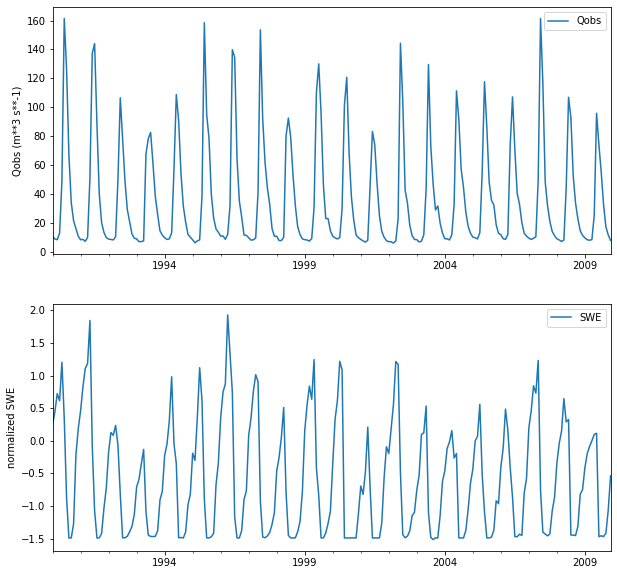

In [22]:
# Plotting the SWE and Qobs data to compare temporal behaviors

# Setting up figure
fig = plt.figure(figsize=(10, 10))
layout = (2,1)
q_ax = plt.subplot2grid(layout, (0,0))
swe_ax = plt.subplot2grid(layout, (1,0))

# Plotting Qobs
q_df.loc['1990-01-01':'2009-12-01'].plot(ax=q_ax)
q_ax.set_xlabel('')
q_ax.set_ylabel('Qobs'+' ('+stationsq_fcaggreg_da.attrs['units']+')')

# Plotting SWE
swe_df = SWE_normmonthlybasinmeans_ds.sel(basin_id=basin_of_interest).to_dataframe()
swe_df.loc['1990-01-01':'2009-12-01'].plot(ax=swe_ax)
swe_ax.set_xlabel('')
swe_ax.set_ylabel('normalized SWE');

In [25]:
# Combining Qobs and SWE data into a single DataFrame for forecasting
# Note: for this model, we regress against the raw Qobs data (unlike the SARIMAX modelling)

q_swe_df = q_df.copy()
swe_df = swe_df.reindex(q_df.index)
q_swe_df['SWE'] = swe_df['SWE']
q_swe_df = q_swe_df.dropna()
display(q_swe_df)

,Qobs,SWE
time,,
1937-03-01,5.936774,-0.651360
1937-04-01,6.973333,-1.488514
1937-05-01,37.877419,-1.488514
1937-06-01,90.903333,-1.488514
1937-07-01,85.451613,-1.488514
...,...,...
2014-08-01,63.532258,-1.493819
2014-09-01,49.040000,-1.502816
2014-10-01,32.967742,-1.493803


Text(0, 0.5, 'SWE nomalized monthly means')

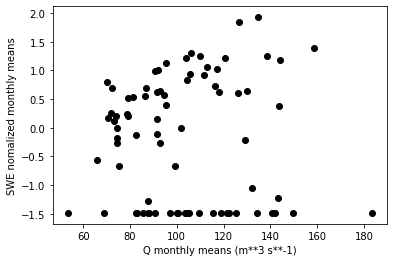

In [26]:
# Plotting Q vs SWE to see correlation

plt.scatter(q_swe_df['Qobs'][q_swe_df['Qobs'].index.month == 7], q_swe_df['SWE'][q_swe_df['SWE'].index.month == 4], color='k')
plt.xlabel('Q monthly means'+' ('+stationsq_fcaggreg_da.attrs['units']+')')
plt.ylabel('SWE nomalized monthly means')

In [27]:
# Splitting the dataset into a training and validation timeseries for forecasting

# Removing years we don't "trust" in SWE data before splitting dataset
q_swe_df_qc = q_swe_df#['1980':]

# Here we split the timeseries in half
split_point_swe = int(len(q_swe_df_qc.index)/2)
training_q_swe, validation_q_swe = q_swe_df_qc[0:split_point_swe], q_swe_df_qc[split_point_swe:]
display(training_q_swe, validation_q_swe)

,Qobs,SWE
time,,
1937-03-01,5.936774,-0.651360
1937-04-01,6.973333,-1.488514
1937-05-01,37.877419,-1.488514
1937-06-01,90.903333,-1.488514
1937-07-01,85.451613,-1.488514
...,...,...
1975-09-01,35.076667,-1.488514
1975-10-01,21.535484,-1.488514
1975-11-01,15.637667,-1.488514


,Qobs,SWE
time,,
1976-02-01,7.764483,0.184388
1976-03-01,7.684194,0.649021
1976-04-01,10.841000,-1.217066
1976-05-01,66.829032,2.283193
1976-06-01,97.146667,-1.488514
...,...,...
2014-08-01,63.532258,-1.493819
2014-09-01,49.040000,-1.502816
2014-10-01,32.967742,-1.493803


In [40]:
# Fitting the model using the formula below

# Function to lag parameters with a given time step
def lag(x, n):
    if n == 0:
        return x
    if isinstance(x, pd.Series):
        return x.shift(n) 
    else:
        x = pd.Series(x)
        return x.shift(n) 

    x = x.copy()
    x[n:] = x[0:-n]
    x[:n] = np.nan
    return x

# OLS model fitting on the training dataset
ols_model = smf.ols(formula = 'Qobs ~ 1 + lag(SWE, 0) + lag(SWE, 1) + lag(SWE, 2) + lag(SWE, 3) + lag(SWE, 4) + lag(Qobs, 1) + lag(Qobs, 2) + lag(Qobs, 3) + lag(Qobs, 4) + lag(Qobs, 12)', data = training_q_swe)
model_fit_exog = ols_model.fit()

# We print a summary of the model
print(model_fit_exog.summary())

                            OLS Regression Results                            
Dep. Variable:                   Qobs   R-squared:                       0.841
Model:                            OLS   Adj. R-squared:                  0.838
Method:                 Least Squares   F-statistic:                     235.7
Date:                Tue, 09 Mar 2021   Prob (F-statistic):          1.38e-170
Time:                        14:51:37   Log-Likelihood:                -1923.8
No. Observations:                 455   AIC:                             3870.
Df Residuals:                     444   BIC:                             3915.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        17.1504      3.077      5.574

<b>Interpretation of the model results</b>

The p-value for each term tests the null hypothesis that the coefficient is equal to zero (no effect). A low p-value (< 0.05) indicates that you can reject the null hypothesis. In other words, a predictor that has a low p-value is likely to be a meaningful addition to your model because changes in the predictor's value are related to changes in the response variable. Conversely, a larger (insignificant) p-value suggests that changes in the predictor are not associated with changes in the response.

Regression coefficients represent the mean change in the response variable for one unit of change in the predictor variable while holding other predictors in the model constant. This statistical control that regression provides is important because it isolates the role of one variable from all of the others in the model.

The R-squared value tells us about the efficacy of the model. It represents the percentage variation in the predictand that is explained by the predictor(s). The higher the value, the better the explainability of the model, with the highest value being one.

We can tweak the formula to drop (add) predictands we think may be insignificant (important).

In [29]:
# Saving model

model_fit_exog.save('ols_model.pkl', remove_data=False)

# To load model back do: loaded = sm.load('ols_model.pkl')

In [41]:
# Out of sample forecasting
# Note: we lose X time steps of data at the start because of the lag in the predictors

# We now generate forecasts for the time series we left out for the validation
fcst_exog = model_fit_exog.get_prediction(exog=validation_q_swe)
print(fcst_exog.summary_frame(alpha=0.01))

          mean   mean_se  mean_ci_lower  mean_ci_upper  obs_ci_lower  \
0     9.365907  1.249126       6.134482      12.597332    -34.216767   
1    13.581354  1.436841       9.864322      17.298385    -30.040014   
2    19.770640  1.605606      15.617022      23.924258    -23.890097   
3    60.934514  1.887610      56.051365      65.817663     17.198344   
4    90.159517  1.852695      85.366693      94.952340     46.433340   
..         ...       ...            ...            ...           ...   
450  80.623629  4.373159      69.310496      91.936762     35.712668   
451  52.820973  4.160208      42.058734      63.583213      8.045609   
452  22.525743  2.976640      14.825332      30.226153    -21.613851   
453  12.265729  1.783764       7.651225      16.880232    -31.441262   
454   9.853578  1.115446       6.967977      12.739179    -33.704821   

     obs_ci_upper  
0       52.948582  
1       57.202721  
2       63.431377  
3      104.670684  
4      133.885694  
..            .

In [42]:
# Writing forecast to new DataFrame
# Note: no transformation needed this time!

# We need to define the longest lag we used in our model formula
maxlag = 12

# We save the forecast mean & confidence intervals to a new DataFrame
forecast_exog_df = pd.DataFrame(fcst_exog.predicted_mean, index=validation_q_swe.index[maxlag::], columns=["Qfc"])
forecast_exog_df['lower_conf_int'] = fcst_exog.conf_int(alpha=0.05)[:,0]
forecast_exog_df['upper_conf_int'] = fcst_exog.conf_int(alpha=0.05)[:,1]

# We set all negative forecast values to 0, just in case
forecast_exog_df[forecast_exog_df < 0] = 0
display(forecast_exog_df)

,Qfc,lower_conf_int,upper_conf_int
time,,,
1977-02-01,9.365907,6.910972,11.820842
1977-03-01,13.581354,10.757500,16.405207
1977-04-01,19.770640,16.615108,22.926171
1977-05-01,60.934514,57.224753,64.644275
1977-06-01,90.159517,86.518377,93.800657
...,...,...,...
2014-08-01,80.623629,72.028967,89.218291
2014-09-01,52.820973,44.644828,60.997118
2014-10-01,22.525743,16.675690,28.375796


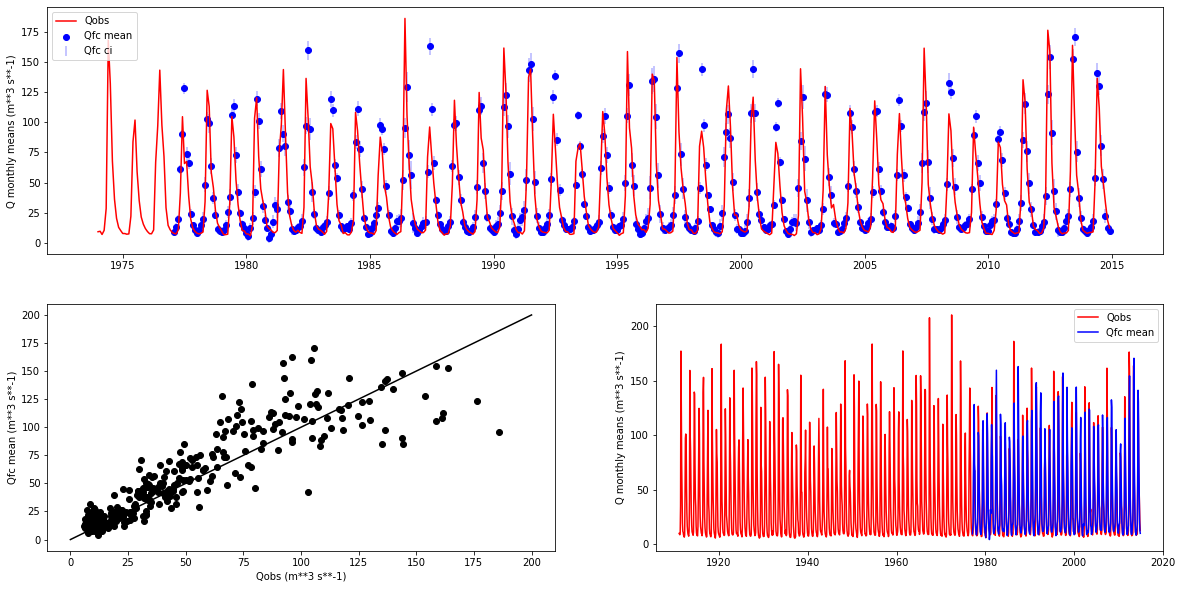

In [43]:
# Forecast plots

# Setting up figure
fig = plt.figure(figsize=(20, 10))
layout = (2,2)
ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
scatter_ax = plt.subplot2grid(layout, (1,0))
tsmean_ax = plt.subplot2grid(layout, (1,1))

# Calculating error bars for timeseries plot
errors_exog = np.zeros((2,len(forecast_exog_df.index)))
errors_exog[0,:] = forecast_exog_df['Qfc'].values - forecast_exog_df['lower_conf_int'].values
errors_exog[1,:] = forecast_exog_df['upper_conf_int'].values - forecast_exog_df['Qfc'].values

# Timeseries plot
ts_ax.plot(q_df[str(forecast_exog_df['Qfc'].index[0].year-3):].index, q_df[str(forecast_exog_df['Qfc'].index[0].year-3):].values, color='red', label='Qobs')
ts_ax.scatter(forecast_exog_df['Qfc'].index, forecast_exog_df['Qfc'].values, color='blue', label='Qfc mean')
ts_ax.errorbar(forecast_exog_df['Qfc'].index, forecast_exog_df['Qfc'].values, yerr=errors_exog, color='blue', alpha=.3, ls='none', label='Qfc ci')
ts_ax.set_ylabel('Q monthly means'+' ('+stationsq_fcaggreg_da.attrs['units']+')')
ts_ax.legend()

# Scatter plot forecast mean vs obs
scatter_ax.scatter(q_df.loc[validation_q_swe.index[maxlag::]].values, forecast_exog_df['Qfc'].values, color='k')
scatter_ax.plot([0,200], [0,200], color='k')
scatter_ax.set_xlabel('Qobs'+' ('+stationsq_fcaggreg_da.attrs['units']+')')
scatter_ax.set_ylabel('Qfc mean'+' ('+stationsq_fcaggreg_da.attrs['units']+')')

# Forecast mean timeseries
tsmean_ax.plot(q_df.index, q_df.values, color='red', label='Qobs')
tsmean_ax.plot(forecast_exog_df['Qfc'].index, forecast_exog_df['Qfc'].values, color='blue', label='Qfc mean')
tsmean_ax.set_ylabel('Q monthly means'+' ('+stationsq_fcaggreg_da.attrs['units']+')')
tsmean_ax.legend();

In [44]:
# Calculating a few forecast verification metrics

print('OLS forecast verification:')

# Correlation
r_exog = stats.pearsonr(q_df.loc[forecast_exog_df.index].values.flatten(), forecast_exog_df['Qfc'].values)[0]
print('Correlation = ', round(r_exog, 2))

# KGE
kge_prime_flow_exog = kgeprime(q_df.loc[forecast_exog_df.index].values.flatten(), forecast_exog_df['Qfc'].values)[0][0]
kge_flow_inv_exog = evaluator(kge, forecast_exog_df['Qfc'].values, q_df.loc[forecast_exog_df.index].values.flatten(), axis=1, transform='inv')[0][0]
print("KGE' = ", round(kge_prime_flow_exog,2))
print('KGE (of inverse of flow) = ', round(kge_flow_inv_exog,2))

OLS forecast verification:
Correlation =  0.92
KGE' =  0.83
KGE (of inverse of flow) =  0.66


### Collate different forecasts
We will make use of the SWE-driven OLS forecasts for the high flow months (when SWE is expected to have some impact on the streamflow) and use the SARIMAX forecasts for the recession/low flow months.

In [54]:
# Collating forecasts, using OLS results for high flow months defined below

high_flow_months = [5, 6, 7, 8]

forecast_collated_df = forecast_df.copy()

for m in high_flow_months:
    intersecting_indeces = forecast_collated_df.index.intersection(forecast_exog_df.index[forecast_exog_df.index.month == m])
    forecast_collated_df.loc[intersecting_indeces[:]] = np.nan

forecast_collated_df = forecast_collated_df.combine_first(forecast_exog_df)

display(forecast_collated_df)

,Qfc,lower_conf_int,upper_conf_int
time,,,
1963-07-01,104.021204,75.724579,132.317829
1963-08-01,58.450886,29.378690,87.523082
1963-09-01,34.734335,5.660280,63.808389
1963-10-01,22.359210,0.000000,51.433398
1963-11-01,14.392525,0.000000,43.466722
...,...,...,...
2014-08-01,80.623629,72.028967,89.218291
2014-09-01,40.917174,0.430589,81.403758
2014-10-01,19.362601,0.000000,59.849185


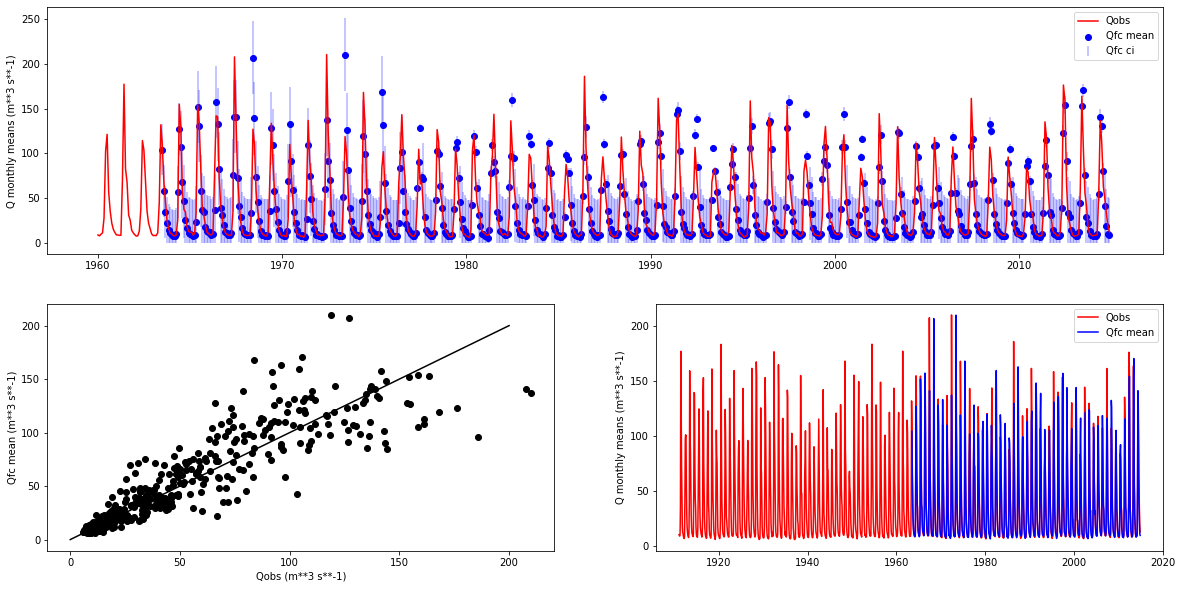

In [55]:
# Forecast plots

# Setting up figure
fig = plt.figure(figsize=(20, 10))
layout = (2,2)
ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
scatter_ax = plt.subplot2grid(layout, (1,0))
tsmean_ax = plt.subplot2grid(layout, (1,1))

# Calculating error bars for timeseries plot
errors_collated = np.zeros((2,len(forecast_collated_df.index)))
errors_collated[0,:] = forecast_collated_df['Qfc'].values - forecast_collated_df['lower_conf_int'].values
errors_collated[1,:] = forecast_collated_df['upper_conf_int'].values - forecast_collated_df['Qfc'].values

# Timeseries plot
ts_ax.plot(q_df['1960':].index, q_df['1960':].values, color='red', label='Qobs')
ts_ax.scatter(forecast_collated_df['Qfc'].index, forecast_collated_df['Qfc'].values, color='blue', label='Qfc mean')
ts_ax.errorbar(forecast_collated_df['Qfc'].index, forecast_collated_df['Qfc'].values, yerr=errors_collated, color='blue', alpha=.3, ls='none', label='Qfc ci')
ts_ax.set_ylabel('Q monthly means'+' ('+stationsq_fcaggreg_da.attrs['units']+')')
ts_ax.legend()

# Scatter plot forecast mean vs obs
scatter_ax.scatter(q_df.loc[forecast_collated_df.index].values, forecast_collated_df['Qfc'].values, color='k')
scatter_ax.plot([0,200], [0,200], color='k')
scatter_ax.set_xlabel('Qobs'+' ('+stationsq_fcaggreg_da.attrs['units']+')')
scatter_ax.set_ylabel('Qfc mean'+' ('+stationsq_fcaggreg_da.attrs['units']+')')

# Forecast mean timeseries
tsmean_ax.plot(q_df.index, q_df.values, color='red', label='Qobs')
tsmean_ax.plot(forecast_collated_df['Qfc'].index, forecast_collated_df['Qfc'].values, color='blue', label='Qfc mean')
tsmean_ax.set_ylabel('Q monthly means'+' ('+stationsq_fcaggreg_da.attrs['units']+')')
tsmean_ax.legend();

In [56]:
# Calculating a few forecast verification metrics

print('Collated forecast verification:')

# Correlation
r_collated = stats.pearsonr(q_df.loc[forecast_collated_df.index].values.flatten(), forecast_collated_df['Qfc'].values)[0]
print('Correlation = ', round(r_collated, 2))

# KGE
kge_prime_flow_collated = kgeprime(q_df.loc[forecast_collated_df.index].values.flatten(), forecast_collated_df['Qfc'].values)[0][0]
kge_flow_inv_collated = evaluator(kge, forecast_collated_df['Qfc'].values, q_df.loc[forecast_collated_df.index].values.flatten(), axis=1, transform='inv')[0][0]
print("KGE' = ", round(kge_prime_flow_collated,2))
print('KGE (of inverse of flow) = ', round(kge_flow_inv_collated,2))

Collated forecast verification:
Correlation =  0.92
KGE' =  0.91
KGE (of inverse of flow) =  0.94


In [70]:
# Combine Qobs and Qfc into single dataset for verification

q_fc_obs = forecast_collated_df.copy()
q_fc_obs['Qobs'] = q_df.loc[forecast_collated_df.index].values
display(q_fc_obs)

,Qfc,lower_conf_int,upper_conf_int,Qobs
time,,,,
1963-07-01,104.021204,75.724579,132.317829,109.332258
1963-08-01,58.450886,29.378690,87.523082,67.519355
1963-09-01,34.734335,5.660280,63.808389,45.936667
1963-10-01,22.359210,0.000000,51.433398,25.993548
1963-11-01,14.392525,0.000000,43.466722,16.453333
...,...,...,...,...
2014-08-01,80.623629,72.028967,89.218291,63.532258
2014-09-01,40.917174,0.430589,81.403758,49.040000
2014-10-01,19.362601,0.000000,59.849185,32.967742


In [71]:
# Save forecast datasets for use in other Notebooks

%store q_fc_obs

Stored 'q_fc_obs' (DataFrame)


## Event analysis - in progress

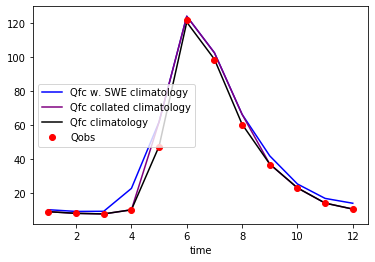

In [43]:
# Climatology plot

ax = forecast_exog_df.loc[forecast_exog_df.index].groupby(forecast_exog_df.index.month).mean()['Qfc'].plot(label='Qfc w. SWE climatology', color='b')
forecast_collated_df.loc[forecast_exog_df.index].groupby(forecast_exog_df.index.month).mean()['Qfc'].plot(label='Qfc collated climatology', color='purple')
forecast_df.loc[forecast_exog_df.index].groupby(forecast_exog_df.index.month).mean()['Qfc'].plot(label='Qfc climatology', color='k')
q_df.loc[forecast_exog_df.index].groupby(q_df.loc[forecast_exog_df.index].index.month).mean().plot(ax = ax, label='Qobs climatology', color='r', marker='o', lw=0)
plt.legend();

In [62]:
# Combining forecast and observed timeseries for the evaluation

fc_obs_collated_df = forecast_collated_df.copy()
# fc_obs_collated_df = fc_obs_collated_df.drop(columns=['lower_conf_int','upper_conf_int'])
fc_obs_collated_df['Qobs'] = q_df.loc[forecast_collated_df.index].values
display(fc_obs_collated_df)

,Qfc,lower_conf_int,upper_conf_int,Qobs
time,,,,
1963-07-01,104.021204,75.724579,132.317829,109.332258
1963-08-01,58.450886,29.378690,87.523082,67.519355
1963-09-01,34.734335,5.660280,63.808389,45.936667
1963-10-01,22.359210,0.000000,51.433398,25.993548
1963-11-01,14.392525,0.000000,43.466722,16.453333
...,...,...,...,...
2014-08-01,80.623629,72.028967,89.218291,63.532258
2014-09-01,40.917174,0.430589,81.403758,49.040000
2014-10-01,19.362601,0.000000,59.849185,32.967742


### Contingency table

In [69]:
def contingency_table(forecasts, observations, percentile, sign):
    
    # Combining forecast and observed timeseries for the evaluation
    fc_obs_df = forecasts.copy()
    fc_obs_df['Qobs'] = observations.loc[forecasts.index].values

    # Creating empty contingency table
    contingency_tbl = {'fc_yes': [0, 0], 'fc_no': [0, 0]}
    contingency_tbl_df = pd.DataFrame(data=contingency_tbl, index=['obs_yes','obs_no'])
    
    # Setting the event (i.e., percentile) to use for the contigency table
    ops = {'>=' : operator.ge, '<=' : operator.le}

    # Calculating the Qobs value corresponding to the defined threshold
    event = fc_obs_df.quantile(q=percentile, axis=0)['Qobs']
    print('Qobs (' + str(round(percentile*100)) + 'th percentile) = ' + str(round(event,2)) + ' ' + stationsq_fcaggreg_da.attrs['units'])

    # Calculating error bars for timeseries plot
    errors_fc = np.zeros((2,len(fc_obs_df.index)))
    errors_fc[0,:] = fc_obs_df['Qfc'].values - fc_obs_df['lower_conf_int'].values
    errors_fc[1,:] = fc_obs_df['upper_conf_int'].values - fc_obs_df['Qfc'].values
    
    # Timeseries plot
    plt.figure(figsize=(15,5))
    plt.plot(fc_obs_df.index, fc_obs_df['Qobs'].values, color='red', label='Qobs')
    plt.scatter(fc_obs_df.index, fc_obs_df['Qfc'].values, color='blue', label='Qfc mean')
    plt.errorbar(fc_obs_df.index, fc_obs_df['Qfc'].values, yerr=errors_fc, color='blue', alpha=.3, ls='none', label='Qfc ci')
    plt.plot(fc_obs_df.index, [event]*len(fc_obs_df.index), color='k', label='event threshold', ls='--')
    plt.ylabel('Q monthly means'+' ('+stationsq_fcaggreg_da.attrs['units']+')')
    plt.xlim((fc_obs_df.index[0], fc_obs_df.index[-1]))
    plt.legend();
    
    # Calculating the contingency table values
    # Finding out which data points fall below/above the event threshold
    count = fc_obs_df[ops[sign](fc_obs_df, event)].notnull()

    def category(row):
        if (row['Qfc'] == True) & (row['Qobs'] == True):
            return 1
        elif (row['Qfc'] == True) & (row['Qobs'] == False):
            return 2
        elif (row['Qfc'] == False) & (row['Qobs'] == True):
            return 3
        else:
            return 4

    count['cat'] = count.apply(lambda row: category(row), axis=1)

    # Filling up the contingency table
    count['cat'].value_counts()
    contingency_tbl_df['fc_yes']['obs_yes'] = count['cat'].value_counts()[1]
    contingency_tbl_df['fc_yes']['obs_no'] = count['cat'].value_counts()[2]
    contingency_tbl_df['fc_no']['obs_yes'] = count['cat'].value_counts()[3]
    contingency_tbl_df['fc_no']['obs_no'] = count['cat'].value_counts()[4]

    # Printing a summary of the contingency table

    print('Contingency table for Q' + sign + str(round(percentile*100)) + 'th percentile:')
    display(contingency_tbl_df)

    print('Hits:', contingency_tbl_df['fc_yes']['obs_yes'])
    print('False alarms:', contingency_tbl_df['fc_yes']['obs_no'])
    print('Misses:', contingency_tbl_df['fc_no']['obs_yes'])
    print('Correct negatives:', contingency_tbl_df['fc_no']['obs_no'])
    
    print('Hit rate:', contingency_tbl_df['fc_yes']['obs_yes']/(contingency_tbl_df['fc_yes']['obs_yes']+contingency_tbl_df['fc_no']['obs_yes']))
    print('False alarm rate:', contingency_tbl_df['fc_yes']['obs_no']/(contingency_tbl_df['fc_yes']['obs_no']+contingency_tbl_df['fc_yes']['obs_yes']))
    
    return None

Qobs (90th percentile) = 98.54 m**3 s**-1
Contingency table for Q>=90th percentile:


,fc_yes,fc_no
obs_yes,35,11
obs_no,19,390


Hits: 35
False alarms: 19
Misses: 11
Correct negatives: 390
Hit rate: 0.7608695652173914
False alarm rate: 0.35185185185185186


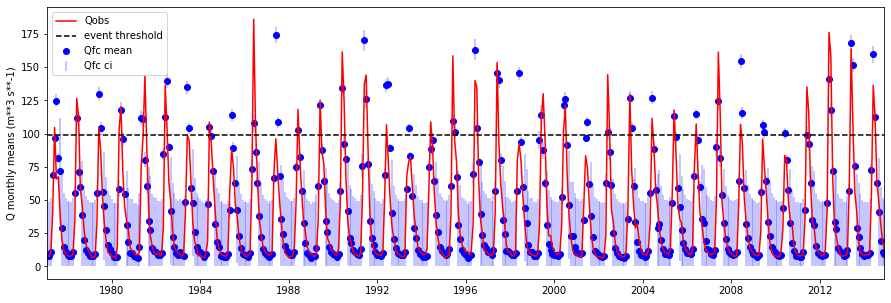

In [70]:
contingency_table(forecast_collated_df.loc[forecast_exog_df.index], q_df, percentile=.9, sign='>=')

Qobs (90th percentile) = 98.54 m**3 s**-1
Contingency table for Q>=90th percentile:


,fc_yes,fc_no
obs_yes,28,18
obs_no,17,392


Hits: 28
False alarms: 17
Misses: 18
Correct negatives: 392
Hit rate: 0.6086956521739131
False alarm rate: 0.37777777777777777


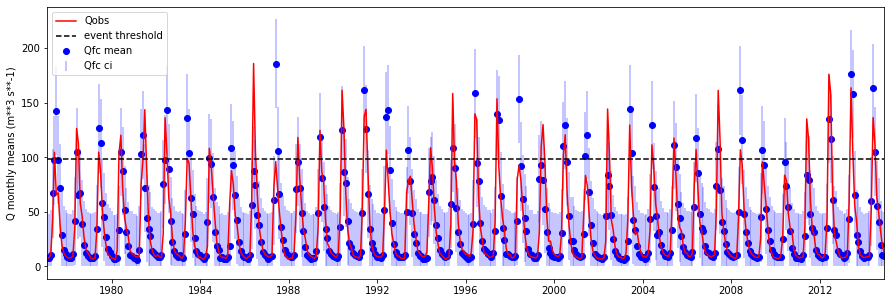

In [71]:
contingency_table(forecast_df.loc[forecast_exog_df.index], q_df, percentile=.9, sign='>=')

Qobs (90th percentile) = 98.54 m**3 s**-1
Contingency table for Q>=90th percentile:


,fc_yes,fc_no
obs_yes,35,11
obs_no,19,390


Hits: 35
False alarms: 19
Misses: 11
Correct negatives: 390
Hit rate: 0.7608695652173914
False alarm rate: 0.35185185185185186


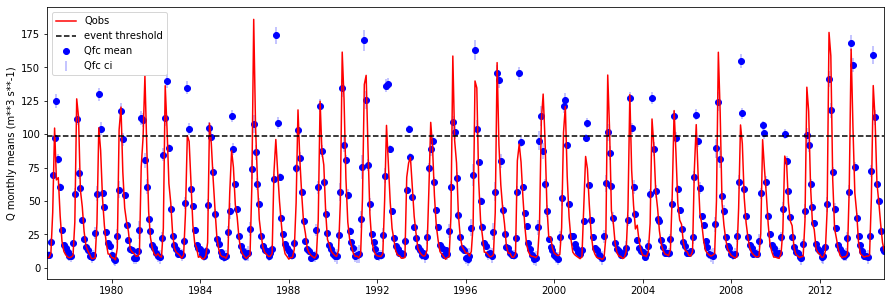

In [72]:
contingency_table(forecast_exog_df, q_df, percentile=.9, sign='>=')

Qobs (25th percentile) = 9.43 m**3 s**-1
Contingency table for Q<=25th percentile:


,fc_yes,fc_no
obs_yes,82,32
obs_no,31,310


Hits: 82
False alarms: 31
Misses: 32
Correct negatives: 310
Hit rate: 0.7192982456140351
False alarm rate: 0.2743362831858407


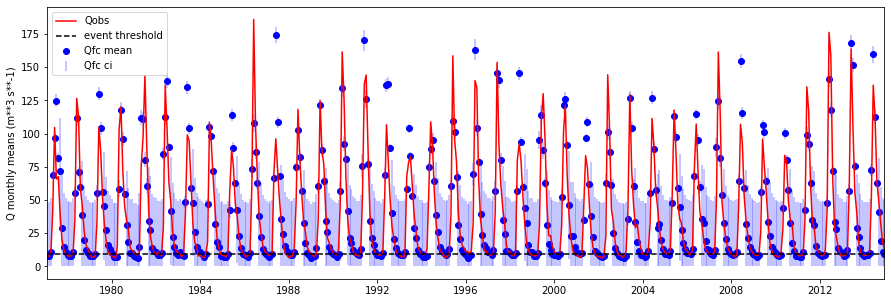

In [73]:
contingency_table(forecast_collated_df.loc[forecast_exog_df.index], q_df, percentile=.25, sign='<=')

Qobs (25th percentile) = 9.43 m**3 s**-1
Contingency table for Q<=25th percentile:


,fc_yes,fc_no
obs_yes,82,32
obs_no,31,310


Hits: 82
False alarms: 31
Misses: 32
Correct negatives: 310
Hit rate: 0.7192982456140351
False alarm rate: 0.2743362831858407


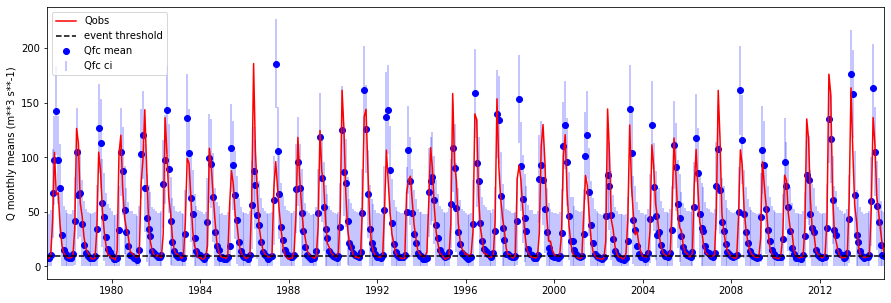

In [74]:
contingency_table(forecast_df.loc[forecast_exog_df.index], q_df, percentile=.25, sign='<=')

Qobs (25th percentile) = 9.43 m**3 s**-1
Contingency table for Q<=25th percentile:


,fc_yes,fc_no
obs_yes,40,74
obs_no,7,334


Hits: 40
False alarms: 7
Misses: 74
Correct negatives: 334
Hit rate: 0.3508771929824561
False alarm rate: 0.14893617021276595


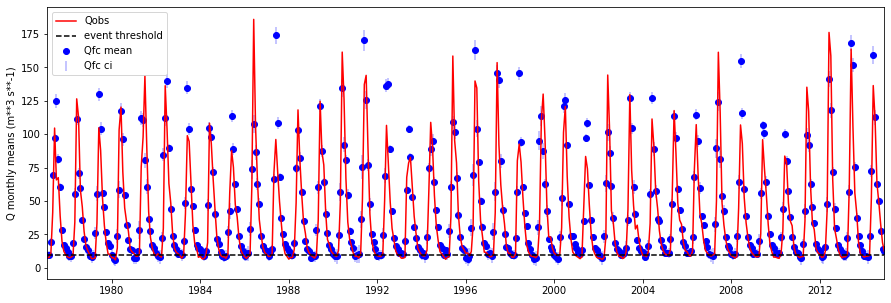

In [75]:
contingency_table(forecast_exog_df, q_df, percentile=.25, sign='<=')

In [63]:
def events_plot(observations, percentiles):

    plt.figure(figsize=(15,5))
    plt.plot(observations.index, observations.values, color='red', label='Qobs')
    
    for p in percentiles:
    
        # Calculating the Qobs value corresponding to the defined threshold
        event = observations.quantile(q=p, axis=0)['Qobs']
        print('Qobs (' + str(round(p*100)) + 'th percentile) = ' + str(round(event,2)) + ' ' + stationsq_fcaggreg_da.attrs['units'])

        # Timeseries plot
        plt.plot(observations.index, [event]*len(observations.index), label=str(round(p*100)) + 'th percentile', ls='--')
    
    plt.ylabel('Q monthly means'+' ('+stationsq_fcaggreg_da.attrs['units']+')')
    plt.xlim((observations.index[0], observations.index[-1]))
    plt.legend();
    
    return None

Qobs (90th percentile) = 98.54 m**3 s**-1
Qobs (25th percentile) = 9.43 m**3 s**-1


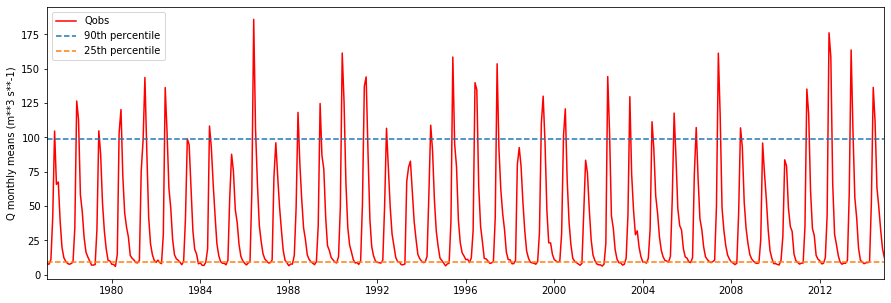

In [65]:
events_plot(q_df.loc[forecast_exog_df.index], percentiles=[.9, .25])

### Flow quantiles

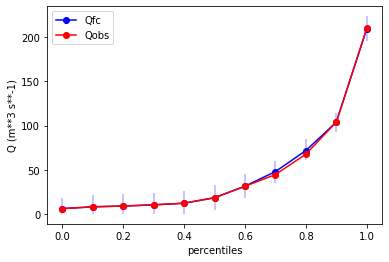

In [72]:
# Plotting the Qfc and Qobs distributions

# Calculating the flow values that correspond to the given quantiles
fc_obs_collated_quantiles = fc_obs_collated_df.quantile(q=np.arange(0,1.1,.1), axis=0)

# Plotting the Qobs and Qfc distributions
fc_obs_collated_quantiles['Qfc'].plot(marker='o', color='blue', label='Qfc')
fc_obs_collated_quantiles['Qobs'].plot(marker='o', color='red', label='Qobs')

# Calculating and adding error bars to the forecast results
ci_verif = np.zeros((2,len(fc_obs_collated_quantiles.index)))
ci_verif[0,:] = fc_obs_collated_quantiles['Qfc'].values - fc_obs_collated_quantiles['lower_conf_int'].values
ci_verif[1,:] = fc_obs_collated_quantiles['upper_conf_int'].values - fc_obs_collated_quantiles['Qfc'].values
plt.errorbar(fc_obs_collated_quantiles['Qfc'].index, fc_obs_collated_quantiles['Qfc'].values, yerr=ci_verif, color='blue', alpha=.3, ls='none')

# Additional plot elements
plt.ylabel('Q'+' ('+stationsq_fcaggreg_da.attrs['units']+')')
plt.xlabel('percentiles')
plt.legend();